In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy.sparse import hstack

import matplotlib.pyplot as plt
import seaborn as sns

import re
import time
import math
import joblib
from collections import Counter, defaultdict

from nltk.corpus import stopwords

from imblearn.over_sampling import SMOTE

from sklearn import svm
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss, normalized_mutual_info_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from mlxtend.classifier import StackingClassifier

In [2]:
# Onehotcode
# Train 
train_x_onehotCoding = joblib.load("data/01_hotcodeencoding/01_train_x.joblib")
# Test
test_x_onehotCoding = joblib.load("data/01_hotcodeencoding/02_test_x.joblib")
# CV
cv_x_onehotCoding = joblib.load("data/01_hotcodeencoding/03_cv_x.joblib")

print("One hot encoding features :")
print("train data = ", train_x_onehotCoding.shape)
print("test data = ", test_x_onehotCoding.shape)
print("cross validation data =", cv_x_onehotCoding.shape)

# Response
# Train 
train_x_responseCoding = joblib.load("data/02_responsecoding/01_train_x.joblib")
# Test
test_x_responseCoding = joblib.load("data/02_responsecoding/02_test_x.joblib")
# CV
cv_x_responseCoding = joblib.load("data/02_responsecoding/03_cv_x.joblib")

print(" Response encoding features :")
print("train data = ", train_x_responseCoding.shape)
print("test data = ", test_x_responseCoding.shape)
print("cross validation data =", cv_x_responseCoding.shape)

# Label
# Train
train_y = joblib.load("data/03_label/01_train_y.joblib")
# Test
test_y = joblib.load("data/03_label/02_test_y.joblib")
# CV
cv_y = joblib.load("data/03_label/01_cv_y.joblib")

print("Label :")
print("train data = ", train_y.shape)
print("test data = ", test_y.shape)
print("cross validation data =", cv_y.shape)

One hot encoding features :
train data =  (2124, 55446)
test data =  (665, 55446)
cross validation data = (532, 55446)
 Response encoding features :
train data =  (2124, 27)
test data =  (665, 27)
cross validation data = (532, 27)
Label :
train data =  (2124,)
test data =  (665,)
cross validation data = (532,)


In [3]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(10,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(10,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(10,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

In [4]:
def BestMLAlgo(nlp_model, x_train, x_test, y_train, y_test):
    """Identify best Algo on given dataset"""
    from prettytable import PrettyTable
    
    table = PrettyTable()
    table.field_names = ["Vect", "Model", "Accuracy", "Precision", "Recall", "F1Score", "Log loss", "Roc Auc"]
                        
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import AdaBoostClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    import xgboost
    from sklearn import svm
    from sklearn.metrics import precision_score, accuracy_score, roc_auc_score,\
                                roc_curve, auc, log_loss, recall_score
    
    base_models = {
        'kNN': KNeighborsClassifier(),
        'Naive Bayes': MultinomialNB(),
        'Log. Reg.': LogisticRegression(),
        'SVM Linear': SGDClassifier(class_weight='balanced', penalty='l2', loss='hinge', random_state=42),
        'SVM Non-linear': svm.SVC(kernel='rbf'),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boost': GradientBoostingClassifier(),
        'Ada Boost': AdaBoostClassifier(),
        'xgboost': xgboost.XGBClassifier(),
    }          
        
    for model_name, model in base_models.items():
        model.fit(x_train, train_y)
        model = CalibratedClassifierCV(model, method="sigmoid")
        model.fit(x_train, train_y)
        y_pred_proba = model.predict_proba(x_test)
        y_pred = model.predict(x_test)
            
        # Performance metrics
        accuracy        = round(accuracy_score(y_test, y_pred), 2)
        precision       = round(precision_score(y_test, y_pred, average='micro'), 2)
        recall          = round(recall_score(y_test, y_pred, average='micro'), 2)
        f1_score        = round((2*recall*precision)/(recall+precision), 2)
        loss            = round(log_loss(y_test, y_pred_proba, eps=1e-15), 2) # , labels=model.classes
        roc_auc         = round(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"), 2)        
        
        table.add_row([nlp_model, model_name, accuracy, precision, recall, f1_score, loss, roc_auc])
    print(table)

<h2>Base Models</h2>

## One hotcode encoding 

In [10]:
BestMLAlgo("BOW", train_x_onehotCoding, test_x_onehotCoding, train_y, test_y)

[10:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:54:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:56:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:58:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

#### CONCLUSION
Best Models for One hotcode encoding
1. Log. Reg.
2. xgboost
3. SVM Linear

## Response encoding

In [11]:
BestMLAlgo("BOW", train_x_responseCoding, test_x_responseCoding, train_y, test_y)

[11:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:06:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:06:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

#### CONCLUSION
Best model for response encoding
1. kNN
2. SVM Linear
3. SVM Non-linear

## For onehot coding 

In [5]:
def logistic_regression_classifier(x_train, x_test, y_train, y_test, x_cv, y_cv):
    c_list = np.array([x for x in range(2, 10)])
    cv_log_error_array = []
    for i in c_list:
        model = LogisticRegression(C=i, class_weight='balanced')
        model.fit(x_train, y_train)
        model = CalibratedClassifierCV(model, method="sigmoid")
        model.fit(x_train, y_train)
        y_pred_proba = model.predict_proba(x_cv)
        cv_log_error_array.append(log_loss(y_cv, y_pred_proba, labels=model.classes_, eps=1e-15))
        
    fig, ax = plt.subplots()
    ax.plot(c_list, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((c_list[i],str(txt)), (c_list[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each inverse of lambda: C")
    plt.xlabel("Inverse lambda C's")
    plt.ylabel("Log loss")
    plt.show()
    
    best_c = np.argmin(cv_log_error_array)
    model = LogisticRegression(C=c_list[best_c], class_weight='balanced')
    model.fit(x_train, y_train)
    model = CalibratedClassifierCV(model, method="sigmoid")
    model.fit(x_train, y_train)

    y_pred_proba = model.predict_proba(x_train)
    print('Best C = ', c_list[best_c], " Train log loss is:", log_loss(y_train, y_pred_proba, labels=model.classes_, eps=1e-15))
    y_pred_proba = model.predict_proba(x_cv)
    print('Best C = ', c_list[best_c], " Cross validation log loss is:", log_loss(y_cv, y_pred_proba, labels=model.classes_, eps=1e-15))
    y_pred_proba = model.predict_proba(y_test)
    print('Best C = ', c_list[best_c], " Test log loss is:", log_loss(y_test, y_pred_proba, labels=model.classes_, eps=1e-15))

In [6]:
def xgboost_classifier(x_train, x_test, y_train, y_test, x_cv, y_cv):
    max_depths = np.array([5, 10, 15]) #  
    estimators = np.array([100, 500, 1000]) #  
    
    cv_log_error_array = []
    for i in estimators:
        for j in max_depths:
            model = XGBClassifier(n_estimators=i, criterion='gini', max_depth=j, 
                        random_state=1, n_jobs=6, class_weight='balanced', verbosity=0)
            model.fit(x_train, y_train)
            model = CalibratedClassifierCV(model, method="sigmoid")
            model.fit(x_train, y_train)
            y_pred_proba = model.predict_proba(x_cv)
            cv_log_error_array.append(log_loss(y_cv, y_pred_proba, labels=model.classes_, eps=1e-15))
    
    cv_log_error_array = np.array(cv_log_error_array) 
    loss_cv = cv_log_error_array.reshape(len(max_depths), len(estimators))
    for es in range(len(estimators)): 
        plt.figure(figsize=(10.0, 8.0))
        ax = sns.heatmap(loss_cv, 
                     annot=True, square=False,  cmap="Oranges",
                     xticklabels=["ne = "+str(ne) for ne in estimators],
                     yticklabels=["md = "+str(md) for md in max_depths])
        plt.title("Cross-val scores for max_depth and num_estimators "+str(estimators[es]))
        plt.show()

    best_estimator = np.argmin(cv_log_error_array)
    model = XGBClassifier(n_estimators=estimators[int(best_estimator/2)], criterion='gini',
                          max_depth=max_depths[int(best_estimator%2)], class_weight='balanced', verbosity=0)  
    model.fit(x_train, y_train)
    model = CalibratedClassifierCV(model, method="sigmoid")
    model.fit(x_train, y_train)
    
    y_pred_proba = model.predict_proba(x_train)
    print('Best estimator = ', estimators[int(best_estimator/2)],'Best max depth = ', max_depths[int(best_estimator%2)], " Train log loss: ",log_loss(y_train, y_pred_proba, labels=model.classes_, eps=1e-15))
    y_pred_proba = model.predict_proba(x_cv)
    print('Best estimator = ', estimators[int(best_estimator/2)],'Best max depth = ', max_depths[int(best_estimator%2)], " CV log loss: ",log_loss(y_cv, y_pred_proba, labels=model.classes_, eps=1e-15))
    y_pred_proba = model.predict_proba(x_test)
    print('Best estimator = ', estimators[int(best_estimator/2)],'Best max depth = ', max_depths[int(best_estimator%2)], " Test log loss: ",log_loss(y_test, y_pred_proba, labels=model.classes_, eps=1e-15))

In [13]:
def svm_linear_classifier(x_train, x_test, y_train, y_test, x_cv, y_cv):
    cList = [10 ** x for x in range(-5, 3)] # 10
    cv_log_error_array = []
    for i in cList:
        model = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
        model.fit(x_train, y_train)
        model = CalibratedClassifierCV(model, method="sigmoid")
        model.fit(x_train, y_train)
        y_pred_proba = model.predict_proba(x_cv)
        cv_log_error_array.append(log_loss(y_cv, y_pred_proba, labels=model.classes_, eps=1e-15))

    fig, ax = plt.subplots()
    ax.plot(cList, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((cList[i],str(txt)), (cList[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each inverse lamda: C")
    plt.xlabel("C's")
    plt.ylabel("Log loss")
    plt.show()

    best_c = np.argmin(cv_log_error_array)
    model = SGDClassifier(class_weight='balanced', alpha=cList[best_c], penalty='l2', loss='hinge', random_state=42)
    model.fit(x_train, y_train)
    model = CalibratedClassifierCV(model, method="sigmoid")
    model.fit(x_train, y_train)
    
    y_pred_proba = model.predict_proba(x_train)
    print('Best C = ', cList[best_c], " Train log loss is:", log_loss(y_train, y_pred_proba, labels=model.classes_, eps=1e-15))
    y_pred_proba = model.predict_proba(x_cv)
    print('Best C = ', cList[best_c], " Cross validation log loss is:", log_loss(y_cv, y_pred_proba, labels=model.classes_, eps=1e-15))
    y_pred_proba = model.predict_proba(x_test)
    print('Best C = ', cList[best_c], " Test log loss is:", log_loss(y_test, y_pred_proba, labels=model.classes_, eps=1e-15))

In [17]:
def svm_non_linear_classifier(x_train, x_test, y_train, y_test, x_cv, y_cv):
    cList = [10 ** x for x in range(-5, 3)]
    cv_log_error_array = []
    for i in cList:
        model = svm.SVC(kernel='rbf', class_weight='balanced')
        model.fit(x_train, y_train)
        model = CalibratedClassifierCV(model, method="sigmoid")
        model.fit(x_train, y_train)
        y_pred_proba = model.predict_proba(x_cv)
        cv_log_error_array.append(log_loss(y_cv, y_pred_proba, labels=model.classes_, eps=1e-15))

    fig, ax = plt.subplots()
    ax.plot(cList, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((cList[i],str(txt)), (cList[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each inverse lamda: C")
    plt.xlabel("C's")
    plt.ylabel("Log loss")
    plt.show()

    best_c = np.argmin(cv_log_error_array)
    model = svm.SVC(kernel='rbf', class_weight='balanced')
    model.fit(x_train, y_train)
    model = CalibratedClassifierCV(model, method="sigmoid")
    model.fit(x_train, y_train)
    
    y_pred_proba = model.predict_proba(x_train)
    print('Best C = ', cList[best_c], " Train log loss is:", log_loss(y_train, y_pred_proba, labels=model.classes_, eps=1e-15))
    y_pred_proba = model.predict_proba(x_cv)
    print('Best C = ', cList[best_c], " Cross validation log loss is:", log_loss(y_cv, y_pred_proba, labels=model.classes_, eps=1e-15))
    y_pred_proba = model.predict_proba(x_test)
    print('Best C = ', cList[best_c], " Test log loss is:", log_loss(y_test, y_pred_proba, labels=model.classes_, eps=1e-15))

In [9]:
def knn_classifier(x_train, x_test, y_train, y_test, x_cv, y_cv):
    kNeighbours = [7, 8, 9]
    cv_log_error_array = []
    for i in kNeighbours:
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(x_train, y_train)
        model = CalibratedClassifierCV(model, method="sigmoid")
        model.fit(x_train, y_train)
        y_pred_proba = model.predict_proba(x_cv)
        cv_log_error_array.append(log_loss(y_cv, y_pred_proba, labels=model.classes_, eps=1e-15))
        
    fig, ax = plt.subplots()
    ax.plot(kNeighbours, cv_log_error_array,c='g')
    for i, txt in enumerate(np.round(cv_log_error_array,3)):
        ax.annotate((kNeighbours[i],str(txt)), (kNeighbours[i],cv_log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each kneighbour")
    plt.xlabel("kNeighbours k's")
    plt.ylabel("Log loss")
    plt.show()
    
    best_k = np.argmin(cv_log_error_array)
    model = KNeighborsClassifier(n_neighbors=kNeighbours[best_k])
    model.fit(x_train, y_train)
    model = CalibratedClassifierCV(model, method="sigmoid")
    model.fit(x_train, y_train)

    y_pred_proba = model.predict_proba(x_train)
    print('Best k = ', kNeighbours[best_k], " Train log loss is:", log_loss(y_train, y_pred_proba, labels=model.classes_, eps=1e-15))
    y_pred_proba = model.predict_proba(x_cv)
    print('Best k = ', kNeighbours[best_k], " Cross validation log loss is:", log_loss(y_cv, y_pred_proba, labels=model.classes_, eps=1e-15))
    y_pred_proba = model.predict_proba(x_test)
    print('Best k = ', kNeighbours[best_k], " Test log loss is:", log_loss(y_test, y_pred_proba, labels=model.classes_, eps=1e-15))

## Onehot coding

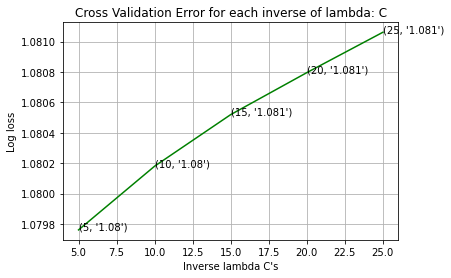

Best C =  5  Train log loss is: 0.5107031048366335
Best C =  5  Cross validation log loss is: 1.0797611409428698
Best C =  5  Test log loss is: 1.0325054511734202


In [20]:
logistic_regression_classifier(train_x_onehotCoding, test_x_onehotCoding, train_y, test_y, cv_x_onehotCoding, cv_y)

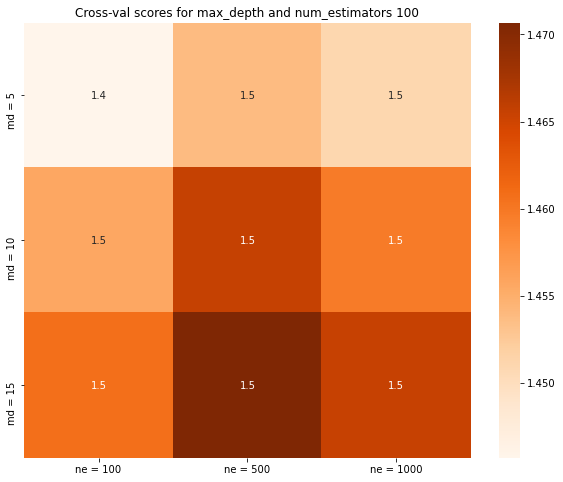

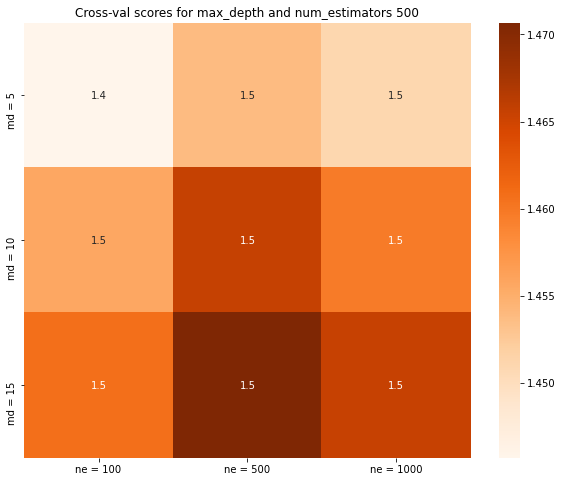

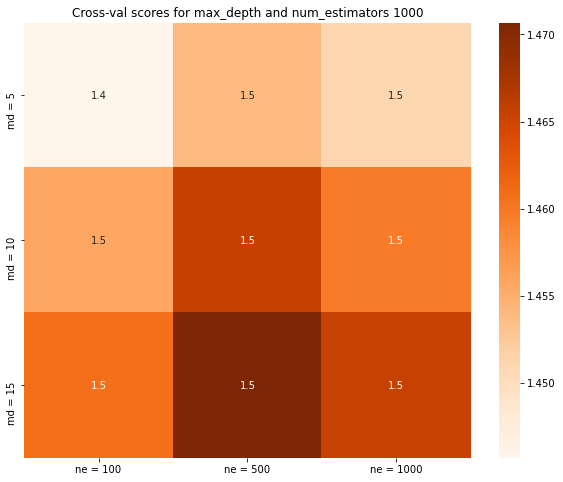

Best estimator =  100 Best max depth =  5  Train log loss:  0.6687998875108129
Best estimator =  100 Best max depth =  5  CV log loss:  1.4457093723972119
Best estimator =  100 Best max depth =  5  Test log loss:  1.429868821073715


In [11]:
xgboost_classifier(train_x_onehotCoding[:500], test_x_onehotCoding[:500], train_y[:500], test_y[:500], cv_x_onehotCoding[:500], cv_y[:500])

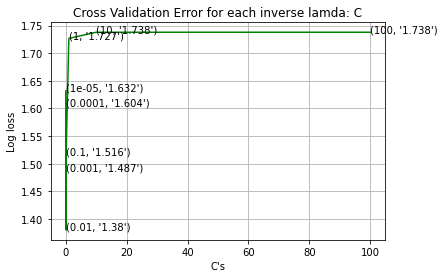

Best C =  0.01  Train log loss is: 0.6396251105979104
Best C =  0.01  Cross validation log loss is: 1.3801713745010327
Best C =  0.01  Test log loss is: 1.342297231653538


In [14]:
svm_linear_classifier(train_x_onehotCoding[:500], test_x_onehotCoding[:500], train_y[:500], test_y[:500], cv_x_onehotCoding[:500], cv_y[:500])

## Response Coding

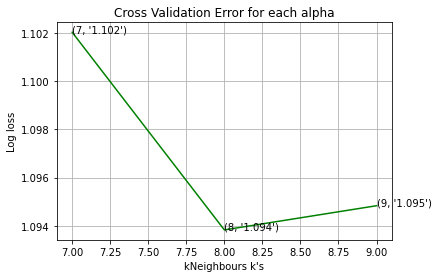

Best k =  8  Train log loss is: 0.5404336301243047
Best k =  8  Cross validation log loss is: 1.0938326402370517
Best k =  8  Test log loss is: 1.025544874185826


In [28]:
knn_classifier(train_x_responseCoding, test_x_responseCoding, train_y, test_y, cv_x_responseCoding, cv_y)

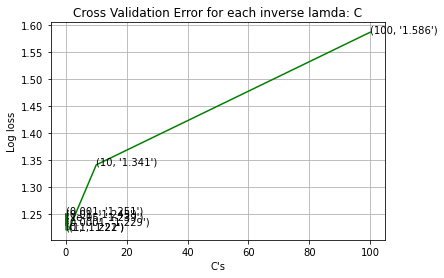

Best C =  0.1  Train log loss is: 0.947726132088464
Best C =  0.1  Cross validation log loss is: 1.2204278544870453
Best C =  0.1  Test log loss is: 1.1896663549327284


In [15]:
svm_linear_classifier(train_x_responseCoding[:500], test_x_responseCoding[:500], train_y[:500], test_y[:500], cv_x_responseCoding[:500], cv_y[:500])

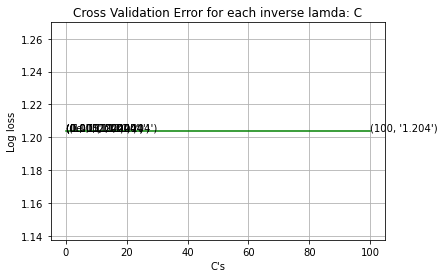

Best C =  1e-05  Train log loss is: 1.0047333050637484
Best C =  1e-05  Cross validation log loss is: 1.2037922223276045
Best C =  1e-05  Test log loss is: 1.2190518711637557


In [18]:
svm_non_linear_classifier(train_x_responseCoding[:500], test_x_responseCoding[:500], train_y[:500], test_y[:500], cv_x_responseCoding[:500], cv_y[:500])

#### CONCLUSION


## Stacking Models on Hotcoding

In [35]:
def log_loss_result_train(x_train, y_train, x_cv, y_cv, models_dict):
    for name, model in base_models.items():
        model.fit(x_train, y_train)
        model = CalibratedClassifierCV(model, method="sigmoid")
        model.fit(x_train, y_train)
        print(f"{name}=>  Log loss (train): {log_loss(y_cv, model.predict_proba(x_cv))}")


base_models = {}
base_models["Logistic Regression"] = LogisticRegression(C=5 , class_weight='balanced')
base_models["SVM Lr"] = SGDClassifier(class_weight='balanced', alpha=0.01, penalty='l2', loss='hinge', random_state=42)
base_models["Xgboost"] = XGBClassifier(n_estimators=100, criterion='gini', max_depth=5, 
                        random_state=1, n_jobs=6, class_weight='balanced', verbosity=0)
log_loss_result_train(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, base_models)

Logistic Regression=>  Log loss (train): 1.147909484714229
SVM Lr=>  Log loss (train): 1.1979181709815983
Xgboost=>  Log loss (train): 1.4388023583611813


In [4]:
def stacking_models(x_train, y_train, x_test, y_test, x_cv, y_cv, *models):
    models_list = []
    for model in models:
        model.fit(x_train, y_train)
        model = CalibratedClassifierCV(model, method="sigmoid")
        models_list.append(model)
        
    alpha = [0.0001,0.001,0.01,0.1,1,10] 
    best_alpha = 999
    for i in alpha:
        lr = LogisticRegression(C=i)
        model = StackingClassifier(classifiers=models_list, meta_classifier=lr, use_probas=True)
        model.fit(x_train, y_train)
        log_error = log_loss(y_cv, model.predict_proba(x_cv))
        print(f"Stacking Classifer: alpha: {i} Log Loss: {log_error}")
        if best_alpha > log_error:
            best_alpha = log_error
            
    # Confusion matrix
    plot_confusion_matrix(y_test, model.predict(x_test)) 
    
    return model   

Stacking Classifer: alpha: 0.0001 Log Loss: 1.8124123861229586
Stacking Classifer: alpha: 0.001 Log Loss: 1.6798527839302073
Stacking Classifer: alpha: 0.01 Log Loss: 1.2679364646436373
Stacking Classifer: alpha: 0.1 Log Loss: 1.1260718553813724
Stacking Classifer: alpha: 1 Log Loss: 1.2902881836417035
Stacking Classifer: alpha: 10 Log Loss: 1.7582944091533161
-------------------- Confusion matrix --------------------


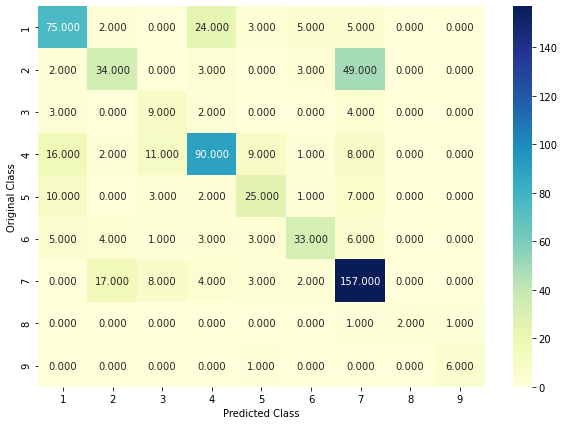

-------------------- Precision matrix (Columm Sum=1) --------------------


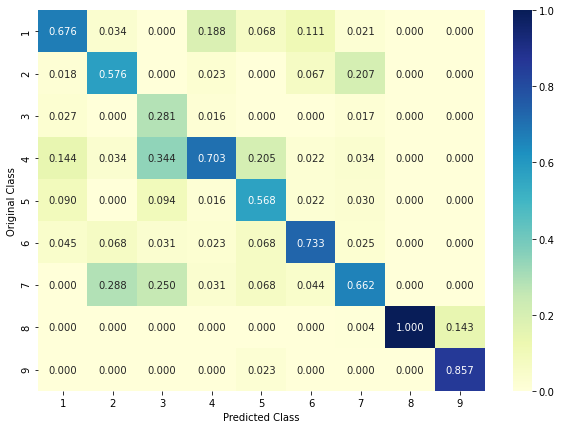

-------------------- Recall matrix (Row sum=1) --------------------


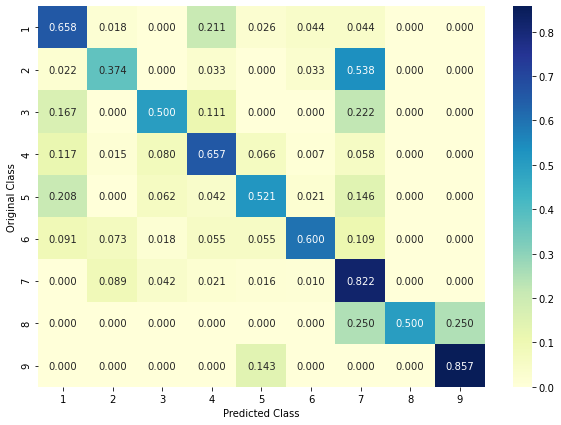

In [6]:
model = stacking_models(train_x_onehotCoding, train_y, test_x_onehotCoding, test_y, cv_x_onehotCoding, cv_y,
            LogisticRegression(C=5 , class_weight='balanced'),
            SGDClassifier(class_weight='balanced', alpha=0.01, penalty='l2', loss='hinge'),
            XGBClassifier(n_estimators=100, criterion='gini', max_depth=5, 
                        random_state=1, n_jobs=6, class_weight='balanced', verbosity=0)
            )

In [7]:
joblib.dump(model, "model/stacking_model.joblib")

['model/stacking_model.joblib']

#### Points

## Votting Classifier on Response Coding

In [4]:
def votting_classifier(x_train, y_train, x_test, y_test, x_cv, y_cv, *models):
    #Refer:http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
    from sklearn.ensemble import VotingClassifier
    
    models_list = []
    for model in models:
        name = str(model).split("(")[0]
        model.fit(x_train, y_train)
        model = CalibratedClassifierCV(model, method="sigmoid")
        models_list.append( tuple((name, model)) )
        
#     print(models_list)
        
    model = VotingClassifier(estimators=models_list, voting='soft')
    model.fit(x_train, y_train)
    
    print("Log loss...")
    print("Train: " , log_loss(y_train, model.predict_proba(x_train)))
    print("CV: "    , log_loss(y_cv, model.predict_proba(x_cv)))
    y_pred_test_proba = model.predict_proba(x_test)
    print("Test: "  , log_loss(y_test, y_pred_test_proba))
    print("-"*20)
    
    y_pred_test = model.predict(x_test)
    print("Missclassified point :", np.count_nonzero((y_pred_test-y_test))/y_test.shape[0])
    
    # Confusion matrix
    plot_confusion_matrix(y_test, y_pred_test)   
    
    return model

Log loss...
Train:  0.47348658616691724
CV:  1.1559471118682663
Test:  1.1374607489865867
--------------------
Missclassified point : 0.3804511278195489
-------------------- Confusion matrix --------------------


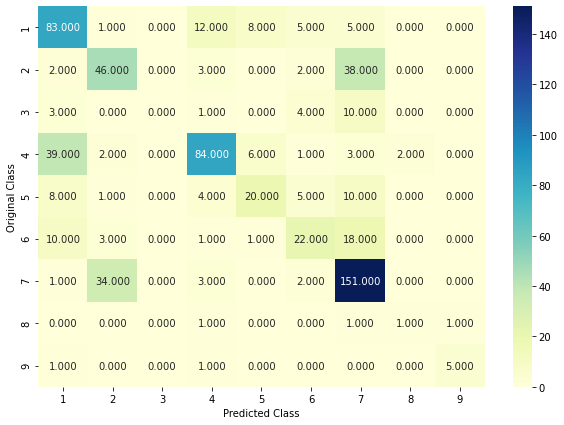

-------------------- Precision matrix (Columm Sum=1) --------------------


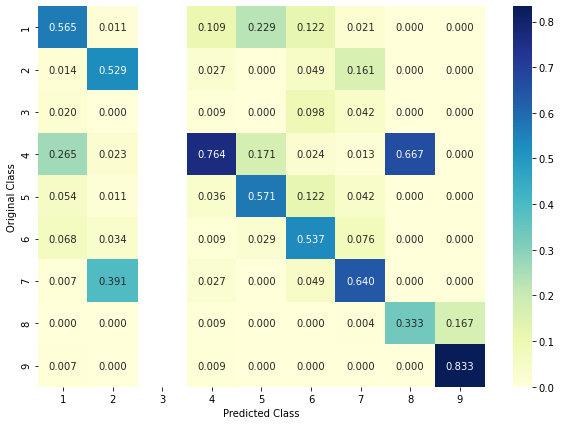

-------------------- Recall matrix (Row sum=1) --------------------


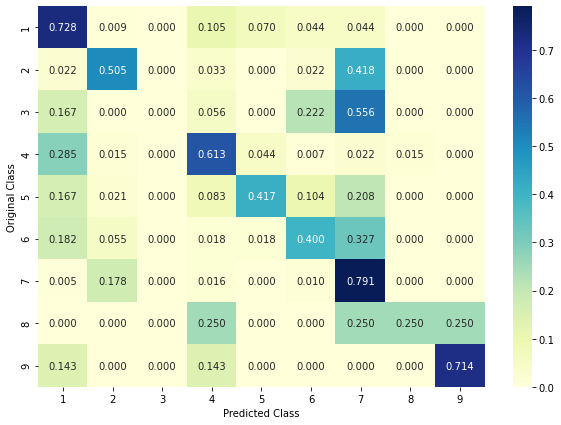

In [5]:
model = votting_classifier(train_x_responseCoding, train_y, test_x_responseCoding, test_y, cv_x_responseCoding, cv_y,
            LogisticRegression(C=5 , class_weight='balanced'),
            SGDClassifier(class_weight='balanced', alpha=0.01, penalty='l2', loss='hinge'),
            XGBClassifier(n_estimators=100, criterion='gini', max_depth=5, 
                    random_state=1, n_jobs=6, class_weight='balanced', verbosity=0)
            )

In [6]:
joblib.dump(model, "model/votting_model.joblib")

['model/votting_model.joblib']

<h3>Feature Importance</h3>

<h4>Correctly Classified point</h4>

In [38]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(x_train_df['Gene'])
    var_vec  = var_count_vec.fit(x_train_df['Variation'])
    text_vec = text_count_vec.fit(x_train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [32]:
df = joblib.load("data/01_combined_data.csv")
Y = df['Class']
X = df 

x_train_df, x_test_df, y_train_df, y_test_df = train_test_split(X, Y, stratify=Y, test_size=0.2)
x_train_df, x_cv_df, y_train_df, y_cv_df = train_test_split(x_train_df, y_train_df, stratify=y_train_df, test_size=0.2)

In [42]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=5, penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding,train_y)

test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])

print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

get_impfeature_names(indices[0], x_test_df['TEXT'].iloc[test_point_index],x_test_df['Gene'].iloc[test_point_index],x_test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1963 0.1485 0.0115 0.1829 0.0566 0.0311 0.3638 0.0084 0.0009]]
Actual Class : 7
--------------------------------------------------
39 Text feature [lead] present in test data point [True]
42 Text feature [whereas] present in test data point [True]
86 Text feature [alterations] present in test data point [True]
90 Text feature [excluding] present in test data point [True]
108 Text feature [whether] present in test data point [True]
169 Text feature [extraction] present in test data point [True]
171 Text feature [infancy] present in test data point [True]
195 Text feature [locus] present in test data point [True]
219 Text feature [studying] present in test data point [True]
222 Text feature [initiated] present in test data point [True]
227 Text feature [frame] present in test data point [True]
233 Text feature [findings] present in test data point [True]
291 Text feature [summary] present in test data point [True]
296 Text feature [l

<h4>Incorrectly Classified point</h4>

In [43]:
test_point_index = 100
no_feature = 10
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)

get_impfeature_names(indices[0], x_test_df['TEXT'].iloc[test_point_index],x_test_df['Gene'].iloc[test_point_index],x_test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.2389 0.1567 0.0059 0.1419 0.0385 0.008  0.3951 0.0151 0.    ]]
Actual Class : 1
--------------------------------------------------
Out of the top  10  features  0 are present in query point


#### CONCLUSION